<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [99]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, CuDNNLSTM
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Preparation

In [100]:
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


## Moving average function

In [0]:
def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

## FOREX data

In [102]:
# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

forexMonthMovAvg = getMovingAverages(forexDataN, 22)
forexMonthMovAvg = np.asarray(forexMonthMovAvg)

# Normalise data
forex_mean = forexMonthMovAvg.mean()
forex_std = forexMonthMovAvg.std()
forexMonthMovAvg = (forexMonthMovAvg - forex_mean) / forex_std

ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

forexData = {'Date':ukFOREXdates,'Value':forexMonthMovAvg}
mainDf = pd.DataFrame(forexData)

print(forex_mean)
print(forex_std)

1.309593875180065
0.16475970732268408


## Interest Rate Data (INT)


### INT data retreival

In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
def cleanDataSets(dataset):

    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    for index, row in mainDf.iterrows():
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        if(value==1000000):
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

In [0]:
def getDifferenceFeatures(xDict, yDict):
    dates = []
    valuesX = []
    valuesY = []
    ratioValues = []                      

    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    diffValues = datasetXarr - datasetYarr

    movingAvg = getMovingAverages(diffValues, 22)
    movingAvg = np.asarray(movingAvg)

    data_mean = movingAvg.mean()
    data_std = movingAvg.std()
    dataNormalised = (movingAvg - data_mean) - data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

ovrRatioMovAvg = getDifferenceFeatures(GBRovrC,EURovrC)
threeMRatioMovAvg = getDifferenceFeatures(GBR3mC,EUR3mC)
sixMRatioMovAvg = getDifferenceFeatures(GBR6mC,EUR6mC)
twelveMRatioMovAvg = getDifferenceFeatures(GBR12mC,EUR12mC)

## Inflation data (CPI)

### CPI data retreival

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [107]:
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        roundD = row['Date'].replace(day=1)

        value= dataset.get(pd.Timestamp(roundD),1000000)

        if(value==1000000):
            clean = False
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    if(clean==True):
        print("Data is clean")

    return cleanedDataDict


ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [0]:
dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)

    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()

ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## International Reserves data (IR)

### IR data retreival

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [110]:
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

In [0]:
IRdates = []
ukIRarr = []
euIRarr = []

for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)


ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)

ukEuIRRatio = ukIRarr / euIRarr

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [113]:
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        if(value==1000000):
            mainDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict


ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [0]:
BOPdates = []
ukBOParr = []
euBOParr = []

for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)

ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

## Creating full data matrix

In [115]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

completeDf = pd.DataFrame(columns=['Date','ForexRate','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0
 
for index, row in mainDf.iterrows():

    date = row['Date']
    forex = row['Value']
    
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)

    ovrI = ovrRatioMovAvg.get(date, 0)
    i3month = threeMRatioMovAvg.get(date, 0)
    i6month = sixMRatioMovAvg.get(date, 0)
    i12month = twelveMRatioMovAvg.get(date, 0)

    completeDf = completeDf.append({'Date':date,
                            'ForexRate':forex,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '1mLIBOR': i1month,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)

#print(completeDf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# Variable Correlation

In [0]:
variables = ['CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

forex = completeDf['ForexRate'].tolist()
correlations = []

for x in range(len(variables)):
    
    column = completeDf[variables[x]].tolist()

    r = np.corrcoef(forex, column)

    correlations.append(r[0,1])

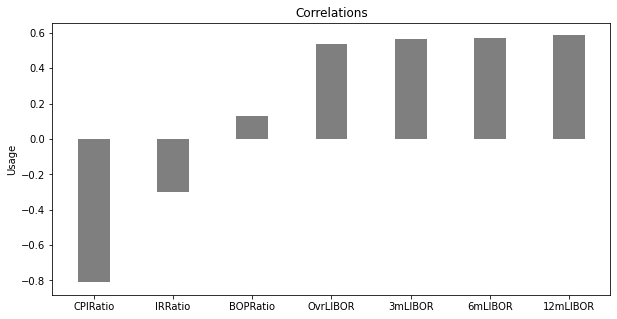

In [118]:
y_pos = np.arange(0,14,2)
plt.figure(figsize=(10,5))
plt.bar(y_pos, correlations, align='center', alpha=0.5, color=(0.0, 0.0, 0.0, 1))
plt.xticks(y_pos, variables)
plt.ylabel('Usage')
plt.title('Correlations')

plt.show()

# Neural Networks

## Data setup

In [0]:
import math

EPOCHS = 10
EVALUATION_INTERVAL = 100
VALIDATION_STEPS = 50
BATCH_SIZE = 30
FOLDS = 5

HISTORY_STEPS = 20
FUTURE_STEPS = 6

features = ['ForexRate']

dataSet = completeDf[features]
dataSet = dataSet.values

fold_steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

for x in range(0,len(dataSet), fold_steps):
    fold_locations.append(x)

## Data splitting functions

In [0]:
def getIndices(currentIndex, steps):

    indices = []

    index = currentIndex

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index - 21
        else:
            indices.append(index)
            index = index - 22

    indices = list(reversed(indices))

    return indices


def singleStepDataSplit(dataset, target, startIndex, endIndex,
                steps, future_steps):  
    data = []
    labels = []

    history_size = 22 * steps

    max_index = 22 * future_steps
    target_size = round(21.75 * future_steps)

    startIndex = startIndex + history_size

    if endIndex is None:
        endIndex = len(dataset) - max_index

    for i in range(startIndex, endIndex):
        dataIndices = getIndices(i,STEPS)
        data.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def getFutureIndices(currentIndex, steps):

    indices = []

    index = currentIndex + 22

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index + 21
        else:
            indices.append(index)
            index = index + 22

    return indices


def splitData(dataset, target, start_index, end_index, steps, future_steps):
    data = []
    labels = []

    history_size = 22 * steps
    target_size = 22 * future_steps

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = getIndices(i,steps)
        data.append(dataset[indices])
        indiciesL = getFutureIndices(i, future_steps)
        labels.append(target[indiciesL])


    return np.array(data), np.array(labels)

## Single-step LSTM

### Building network

In [0]:
def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(HISTORY_STEPS, len(features))),
        layers.Dense(1)
    ])

    singleStepLSTMModel.compile(optimizer='adam', loss='mse')
    return singleStepLSTMModel

### Training models

In [0]:
dataVal = []

def trainModel(history_steps, future_step):

    models = []
    results = []

    for x in range(1, FOLDS):

        model = singleStepLSTM()

        valIndex = fold_locations[x]
        
        if (x==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[x+1]

        xTrain, yTrain = singleStepDataSplit(dataSet, dataSet[:, 0], 0, valIndex, history_steps, future_step)
        xVal, yVal = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, history_steps, future_step)

        dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
        dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()

        dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
        dataVal = dataVal.batch(BATCH_SIZE).repeat()

        print("--------------------- Model validated on fold ", "%d/%d --------------------------" % (x, FOLDS - 1))

        result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=dataVal, validation_steps=50)
        
        models.append(model)
        results.append(result)

    return models

### Single-step tests

In [128]:
def singleStepModelTests(model, xTest, yTest):

    mses = []
    classifications = []

    correctDirection = 0

    noDatapoints = len(xTest)
    noPredictions = 6

    mse = model.evaluate(xTest,yTest)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        prediction = model.predict(past)[0]
        future = yTest[x]

        if((current > prediction) == (current > future)):
                correctDirection = correctDirection + 1

    print("-------------------------------")
    print("MSE: " + str(round(mse,3)))
    directionClass = correctDirection / noDatapoints
    print("Direction classification: " + str(round(directionClass,3)))
    print("-------------------------------")

    mses.append(mse)
    classifications.append(directionClass)

    return mses, classifications


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTest, yTest = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, STEPS, FUTURE_STEPS)

        mses,classifications = singleStepModelTests(models[i-1], xTest, yTest)

        modelMses.append(mses)
        modelClassifications.append(classifications)

        meanMse = np.mean(modelMses)
        meanClass = np.mean(modelClassifications)
    
    print("-------------------------------------------------------------")
    print("Average MSE: " + str(meanMse))
    print("Average classification: " + str(np.mean(classifications)))
    print("-------------------------------------------------------------")

    return meanMse, meanClass

allModels = []
allMses = []
allClassifications = []

def createModelsForAllSteps():

    for i in range(1,FUTURE_STEPS+1):
        futures_step = i

        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month", "%d/%d &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&" % (i, FUTURE_STEPS))

        models = trainModel(HISTORY_STEPS, i)

        modelMses, modelClassifications = runModels(models)

        allModels.append(models)
        allMses.append(modelMses)
        allClassifications.append(modelClassifications)

createModelsForAllSteps()

def correctMaxTest(finalModels):

    valIndex = fold_locations[FOLDS-1]
    endIndex = None
    correctMax = 0

    xTest, yTest = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

    for datapoint in range(len(xTest)):

        past = tf.constant([xTest[datapoint]])
        future = yTest[datapoint]

        predictions = []

        for j in range(months):

            prediction = finalModels[j].predict(past)
            predictions.append(prediction)

        actualMax = np.argmax(future)
        predictedMax = np.argmax(predictions)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1

    #print("---------------")
    bestMonthClass = correctMax / len(xTest)

    #print("Correct best month: " + str(round(bestMonthClass,3)))

    return bestMonthClass


finalModels = []

for i in range(FUTURE_STEPS):
    finalModels.append(allModels[i][-1])

bestClass = correctMaxTest(finalModels)







&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month 1/6 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
--------------------- Model validated on fold  1/4 --------------------------
Epoch 1/10
100/100 [==============================] - 2s 16ms/step - loss: 0.1073 - val_loss: 0.1466
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0561 - val_loss: 0.1374
Epoch 3/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0425 - val_loss: 0.1332
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0316 - val_loss: 0.1389
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0258 - val_loss: 0.1270
Epoch 6/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0223 - val_loss: 0.1159
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0195 - val_loss: 0.1041
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0180 - val_loss: 0.0905
Epoch 9/10
100/100 [================

### Results

In [129]:
def printResults(mses,directionClass,bestClass):

    for i in range(FUTURE_STEPS):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(mses[i]))
        print("Dir: " + str(directionClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

printResults(allMses, allClassifications, bestClass)

-----------
Month 1
MSE: 0.21773412311449647
Dir: 0.4743147387758713
-----------
Month 2
MSE: 0.25337497936561704
Dir: 0.4935455080066406
-----------
Month 3
MSE: 0.27107624523341656
Dir: 0.5042205950466556
-----------
Month 4
MSE: 0.3437245190143585
Dir: 0.5214789776896536
-----------
Month 5
MSE: 0.31653143372386694
Dir: 0.542682133508194
-----------
Month 6
MSE: 0.31957047060132027
Dir: 0.4968241453425135
---------
Bes: 0.1424802110817942


### Prediction visualisation

In [130]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(TIME_LAGS,STEP)

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


for x, y in dataVal.take(1):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                        model.predict(x)[0]], PREDICTION_HORIZON,
                    'Single Step Prediction')
    print(model.predict(x)[0])
    plot.show()

AttributeError: ignored

## Multi-step LSTM

### Building network

In [0]:
def multiStepLSTM():
    multiStepLSTMModel = keras.Sequential([
        layers.LSTM(units=32, return_sequences=True, input_shape = (HISTORY_STEPS, len(features))),
        layers.LSTM(16, activation='relu'),
        layers.Dense(FUTURE_STEPS)
    ])

    multiStepLSTMModel.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return multiStepLSTMModel

multiStepModel = multiStepLSTM()

### Training models

In [132]:
models = []
results = []
dataTrainMulti = []

for x in range(1, FOLDS):

    valIndex = fold_locations[x]

    multiStepModel = multiStepLSTM()
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    xTrainMulti, yTrainMulti = splitData(dataSet, dataSet[:, 0], 0, valIndex, HISTORY_STEPS, FUTURE_STEPS)
    xValMulti, yValMulti = splitData(dataSet, dataSet[:, 0], valIndex, None, HISTORY_STEPS, FUTURE_STEPS)

    dataTrainMulti = tf.data.Dataset.from_tensor_slices((xTrainMulti, yTrainMulti))
    dataTrainMulti = dataTrainMulti.cache().batch(BATCH_SIZE).repeat()

    dataValMulti = tf.data.Dataset.from_tensor_slices((xValMulti, yValMulti))
    dataValMulti = dataValMulti.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    result = multiStepModel.fit(dataTrainMulti, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=dataValMulti, validation_steps=50)
    
    models.append(multiStepModel)
    results.append(result)

--------------------- Model 1/4 --------------------------
Epoch 1/10
100/100 [==============================] - 3s 27ms/step - loss: 0.3138 - val_loss: 0.9895
Epoch 2/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0473 - val_loss: 1.1463
Epoch 3/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0378 - val_loss: 1.1037
Epoch 4/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0364 - val_loss: 1.0269
Epoch 5/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0374 - val_loss: 1.0294
Epoch 6/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0384 - val_loss: 1.1002
Epoch 7/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0383 - val_loss: 1.2323
Epoch 8/10
100/100 [==============================] - 2s 21ms/step - loss: 0.0384 - val_loss: 1.2804
Epoch 9/10
100/100 [==============================] - 2s 22ms/step - loss: 0.0365 - val_loss: 1.1682
Epoch 10/10
100/100 [===========

### Multi-step tests

In [133]:
def multiStepModelTests(model, xTest, yTest):

    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    noDatapoints = len(xTest)
    noPredictions = len(totalSquaredError)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        predictions = model.predict(past)[0]
        future = yTest[x]

        for y in range(noPredictions):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1

    mses = []
    classifications = []


    print("---------------")
    for x in range(noPredictions):
        mse = totalSquaredError[x] / noDatapoints
        mses.append(mse)
        print("MSE (Month " + str(x+1) + "): " + str(round(mse,3)))

    averageMSE = (sum(totalSquaredError) / noDatapoints) / noPredictions
    print("Average MSE: " + str(round(averageMSE,3)))


    print("---------------")
    for x in range(noPredictions):
        percentInterval = correctDirection[x] / noDatapoints
        classifications.append(percentInterval)
        print("Direction (Month " + str(x+1) + "): " + str(round(percentInterval,3)))

    directionClass = (sum(correctDirection) / noDatapoints) / noPredictions
    print("Average classification: " + str(round(directionClass,3)))

    return mses, classifications


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTestMulti, yTestMulti = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        mses, classifications = multiStepModelTests(models[i-1], xTestMulti, yTestMulti)

        modelMses.append(mses)
        modelClassifications.append(classifications)

    monthAverageMses = []
    monthAverageClass = []

    for i in range(FUTURE_STEPS):

        totalMse = 0
        totalClass = 0

        for j in range(len(modelMses)):
            totalMse = totalMse + modelMses[j][i]
            totalClass = totalClass + modelClassifications[j][i]

        meanMse = totalMse / len(modelMses)
        meanClass = totalClass / len(modelMses)

        monthAverageMses.append(meanMse)
        monthAverageClass.append(meanClass)

    print("-------------------------------------------------------------")
    print("Average MSE: " + str(meanMse))
    print("Average classification: " + str(np.mean(classifications)))
    print("-------------------------------------------------------------")

    return monthAverageMses, monthAverageClass

def correctMaxTest(finalModel):

    valIndex = fold_locations[4]
    endIndex = None
    correctMax = 0

    xTestMulti, yTestMulti = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, STEPS, FUTURE_STEPS)

    for datapoint in range(len(xTestMulti)):

        past = tf.constant([xTestMulti[datapoint]])
        future = yTestMulti[datapoint]

        predictions = finalModel.predict(past)[0]

        actualMax = np.argmax(future)
        predictedMax = np.argmax(predictions)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1

    bestMonthClass = correctMax / len(xTestMulti)

    print("Correct best month: " + str(round(bestMonthClass,3)))

    return bestMonthClass

monthAverageMses, monthAverageClass = runModels(models)
bestClass = correctMaxTest(models[-1])

---------------
MSE (Month 1): 0.435
MSE (Month 2): 0.413
MSE (Month 3): 0.461
MSE (Month 4): 0.782
MSE (Month 5): 0.689
MSE (Month 6): 0.776
Average MSE: 0.593
---------------
Direction (Month 1): 0.428
Direction (Month 2): 0.412
Direction (Month 3): 0.381
Direction (Month 4): 0.513
Direction (Month 5): 0.554
Direction (Month 6): 0.611
Average classification: 0.483
---------------
MSE (Month 1): 0.659
MSE (Month 2): 0.851
MSE (Month 3): 0.512
MSE (Month 4): 0.686
MSE (Month 5): 0.498
MSE (Month 6): 0.483
Average MSE: 0.615
---------------
Direction (Month 1): 0.607
Direction (Month 2): 0.609
Direction (Month 3): 0.659
Direction (Month 4): 0.633
Direction (Month 5): 0.582
Direction (Month 6): 0.568
Average classification: 0.61
---------------
MSE (Month 1): 0.166
MSE (Month 2): 0.177
MSE (Month 3): 0.319
MSE (Month 4): 0.193
MSE (Month 5): 0.195
MSE (Month 6): 0.22
Average MSE: 0.212
---------------
Direction (Month 1): 0.564
Direction (Month 2): 0.422
Direction (Month 3): 0.446
Direct

### Results

In [134]:
def printResults(monthAverageMses,monthAverageClass,bestClass):

    for i in range(len(monthAverageMses)):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(monthAverageMses[i]))
        print("Dir: " + str(monthAverageClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

printResults(monthAverageMses, monthAverageClass, bestClass)

-----------
Month 1
MSE: 0.4255993535475884
Dir: 0.539743069324965
-----------
Month 2
MSE: 0.48780561998613103
Dir: 0.5205773524222884
-----------
Month 3
MSE: 0.45124988191689436
Dir: 0.5414864717178498
-----------
Month 4
MSE: 0.5480984739718459
Dir: 0.6422187007228615
-----------
Month 5
MSE: 0.5483305819754664
Dir: 0.6266750974483875
-----------
Month 6
MSE: 0.60780673028778
Dir: 0.6245231664350804
---------
Bes: 0.21372031662269128


### Prediction visualisation

tf.Tensor(
[[[1.59906008]
  [1.6374907 ]
  [1.75694842]
  [1.83452696]
  [2.02618348]
  [2.06806265]
  [1.86702608]
  [1.77041155]
  [1.75576211]
  [1.85069375]
  [1.7999863 ]
  [1.89312469]
  [1.95519856]
  [1.91952678]
  [1.94432874]
  [1.76652159]
  [1.49643128]
  [1.53905534]
  [1.60449499]
  [1.67600409]]

 [[1.595915  ]
  [1.63864941]
  [1.76894936]
  [1.8332303 ]
  [2.02872161]
  [2.07266991]
  [1.84956263]
  [1.77187373]
  [1.75725189]
  [1.85441819]
  [1.80053807]
  [1.89386958]
  [1.95845399]
  [1.91538852]
  [1.94339073]
  [1.75402405]
  [1.48564422]
  [1.55215982]
  [1.60035673]
  [1.68058376]]

 [[1.59061803]
  [1.64369809]
  [1.77675688]
  [1.83607191]
  [2.03236328]
  [2.07120773]
  [1.83618226]
  [1.7726738 ]
  [1.7610315 ]
  [1.85681838]
  [1.80197266]
  [1.89348334]
  [1.96333714]
  [1.91249174]
  [1.94137678]
  [1.73959532]
  [1.47863677]
  [1.56451942]
  [1.59533564]
  [1.68472202]]

 [[1.58769366]
  [1.65100901]
  [1.78621969]
  [1.83816863]
  [2.03594977]
  [2.069

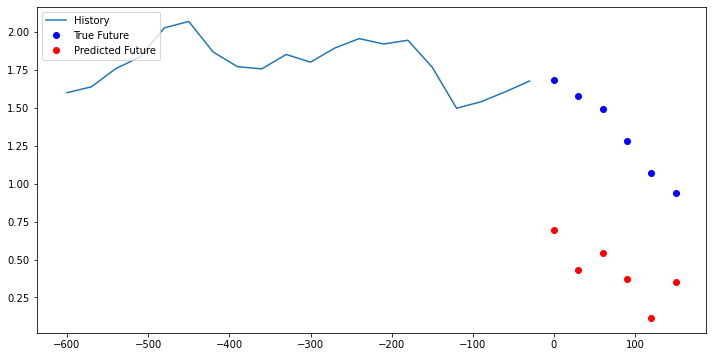

In [135]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(TIME_LAGS,STEP)
  num_out = len(true_future) * FUTURE_STEP

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=FUTURE_STEP), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=FUTURE_STEP), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

model = models[-1]

for x, y in dataTrainMulti.take(1):

    print(x)

    #print((multiStepModel.predict(x)[0]).index(max(multiStepModel.predict(x)[0])))
    print(model.predict(x)[0])
    multi_step_plot(x[0], y[0], model.predict(x)[0])
